Let's start with a cleaned up version of where we ended last time

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
#matplotlib inline

In [30]:
# read all the words
words = open('names.txt', 'r').read().splitlines()

In [31]:
# build vocabulary of characters and stoi, itos mappings
chars = sorted(list(set(''.join(words)))) # a to z
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
print('vocab size: ', vocab_size)
print(stoi)

vocab size:  27
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [32]:
# build the dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr   = build_dataset(words[:n1])     # 80%
Xdev, Ydev  = build_dataset(words[n1:n2])   # 10%
Xte,  Yte   = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [33]:
# Setup NN
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)

# reason for multiplication is described below. This is essentially to ensure low pre-activation outputs so that tanh values are not close to -1 or 1. Training neurons is harder with tanh values closer to the ends because gradient is 0 for those.
# The proper way to do this is to multiply it by gain/sqrt(fan-in). Paper by Kaiming He & others details this.
# gain for tanh is 5/3 (from Kaiming He's paper)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) # 0.2
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01

# setting w2, b2 to almost 0 makes logits small, which is equivalent to assuming everything is likely, and is a good starting point
# we are only setting below 2, based on: logits = h @ W2 + b2
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

# BatchNorm paramaters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

12097


In [35]:
n_steps = 200000
batch_size = 32
lossi = []

for i in range(n_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    # BatchNorm layer
    # --------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
    # --------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} /{n_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

torch.Size([1, 200])
      0 / 200000: 3.2736


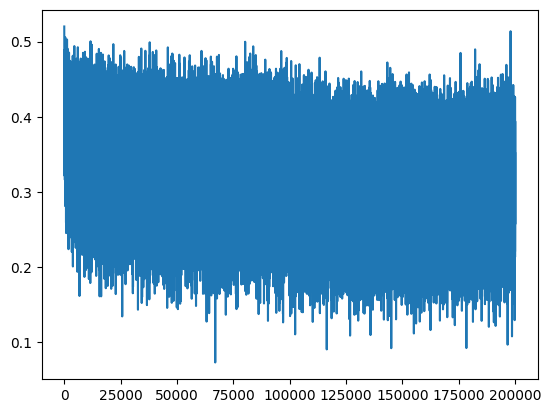

In [294]:
plt.plot(lossi)

In [355]:
@torch.no_grad # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0644943714141846
val 2.1168136596679688


# Loss Log

## Original
train   2.12
val     2.16

## fix softmax confidently wrong. Decrease (W2, b2)
train   2.07
val     2.13

## fix tanh layer too saturated in init (many values close to -1, 1). Decrease (W1, b1)
train   2.03
val     2.10

## use semi-principled kaiming init
train   2.03
val     2.11

## with batch normalization
train   2.06
val     2.11

# Some of the results are similar because this is a very simple NN. In more complex NN, these optimizations will make a bigger impact.  

# It's important to be concerned about tanh histograms (see below)

the gradient for tanh is 1-t**2, which essentially becomes 0 at values close to 1,-1
the saving grace is that, in general, the tanh values are not close to 1 or -1 for _all_ training inputs, so it's unlikely to be a dead neuron.
There are several values close to -1, 1 because the pre-activations that feed into tanh have a broad range [-20..20], many of which will end up close to -1 or 1 

we can address this issue by bringing down the pre-activations by reducing initial W1 and b1

Note: The deeper the network is, and the more complex the network is, the less forgiving it is to some of these errors. 
We are seeing a small difference in our simple network, we'll see much more in larger networks.


In [333]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the NN
        emb = C[torch.tensor(context)]
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1)
        logits = h @ W2 + b2 
        prob = F.softmax(logits, dim=1)
        
        # sample from distribution
        ix = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(itos[ix])
        # break if we sample the ending character
        if ix == 0:
            break
    print(''.join(out))
        
    

carmahzari.
harli.
jari.
ree.
casparsha.
jazhita.
deliah.
jareei.
ner.
kiah.


(array([601., 283., 214., 161., 127., 149.,  88., 110., 105.,  97., 111.,
         72.,  58.,  69.,  81.,  83.,  74.,  75.,  68.,  63.,  62.,  66.,
         53.,  49.,  53.,  87.,  71.,  57.,  65.,  86.,  59.,  59.,  76.,
         79.,  83.,  88.,  63.,  94.,  63.,  99.,  97.,  78., 122., 113.,
        146., 160., 197., 274., 332., 780.]),
 array([-9.99992251e-01, -9.59992634e-01, -9.19993017e-01, -8.79993399e-01,
        -8.39993782e-01, -7.99994165e-01, -7.59994547e-01, -7.19994930e-01,
        -6.79995313e-01, -6.39995695e-01, -5.99996078e-01, -5.59996461e-01,
        -5.19996843e-01, -4.79997226e-01, -4.39997609e-01, -3.99997991e-01,
        -3.59998374e-01, -3.19998757e-01, -2.79999139e-01, -2.39999522e-01,
        -1.99999905e-01, -1.60000287e-01, -1.20000670e-01, -8.00010526e-02,
        -4.00014353e-02, -1.81794167e-06,  3.99977994e-02,  7.99974167e-02,
         1.19997034e-01,  1.59996651e-01,  1.99996269e-01,  2.39995886e-01,
         2.79995503e-01,  3.19995121e-01,  3.59994

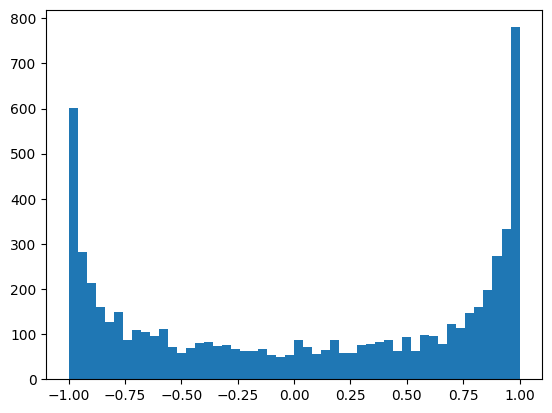

In [327]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  2.,   0.,   1.,   4.,   2.,   2.,   4.,  12.,  12.,  13.,  22.,
         28.,  36.,  65.,  65., 119., 146., 176., 198., 241., 281., 300.,
        375., 370., 381., 373., 420., 364., 365., 324., 314., 310., 232.,
        169., 162., 145.,  96.,  78.,  48.,  34.,  36.,  18.,  19.,  12.,
          9.,   4.,   7.,   3.,   2.,   1.]),
 array([-6.22911835, -5.98374928, -5.7383802 , -5.49301113, -5.24764206,
        -5.00227299, -4.75690392, -4.51153484, -4.26616577, -4.0207967 ,
        -3.77542763, -3.53005856, -3.28468948, -3.03932041, -2.79395134,
        -2.54858227, -2.3032132 , -2.05784412, -1.81247505, -1.56710598,
        -1.32173691, -1.07636784, -0.83099876, -0.58562969, -0.34026062,
        -0.09489155,  0.15047752,  0.3958466 ,  0.64121567,  0.88658474,
         1.13195381,  1.37732288,  1.62269196,  1.86806103,  2.1134301 ,
         2.35879917,  2.60416824,  2.84953732,  3.09490639,  3.34027546,
         3.58564453,  3.8310136 ,  4.07638268,  4.32175175,  4.56712082,
 

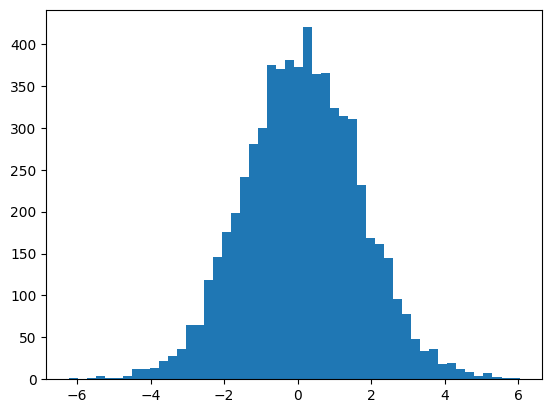

In [328]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

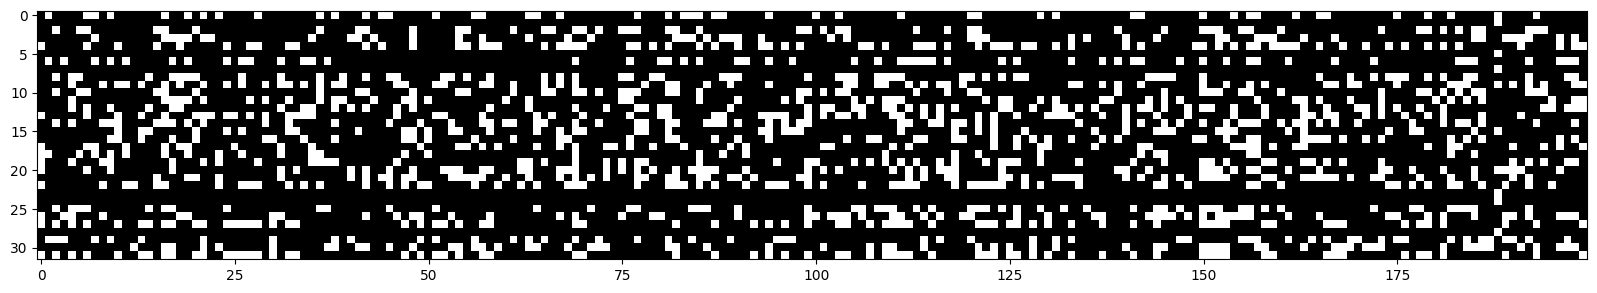

In [336]:
plt.figure(figsize=(20,10)) # large image to see easily
plt.imshow(h.abs() > 0.99, cmap = 'gray') # white pixels are the true ones

# Here, if there is a line of white, then it's a big issue, since it would essentially be a dead neuron that never learns.
# We don't see such a case here.

# Batch Normalization

The idea behind this is the following -
We want the hidden state activations to not be too small and not be too large. We want them to follow a gaussian distribution.
So, the insight is that we standardize these activations so that they are roughly a gaussian distribution.
we want mean=0,std=1 => we subtract mean from hpreact and divide hpreact by std
we want to give the freedom to spike and shift activations, so we maintain BN gains and biases that can be tuned.
Important to note that the mean, variance are for a specific neuron across the batch of examples (we are coupling batches together, not neurons together in a single layer).

With batch normalization, the network is more forgiving to mistakes in initializations.


An important thing to note with batch normalization is that it couples the examples in the batch together.
In a strange way, this turns out to be good for the NN training. In a way, it is kind of like a regularizer.
It's introducing entropy that makes it harder for the NN to over-fit.

But, this can cause bugs that are hard to understand. So, many people have moved to other normalization techniques that do not couple batch examples together.
Example: instance normalization, group normalization, ...
BatchNorm was the first one introduced (at 2015)

The NN expects batch as an input now (based on the forward pass) that it's been trained with which couples examples together.
Since we want to feed a single example in reality (trained model), we'll maintain global mean/std that we can apply for live use-cases.
With BatchNorm, the b1 is useless since we subtract the mean which undoes any bias that we add. The b1.grad would always be 0. 

It's normal to keep BatchNorm layers across the NN, it's usual to have it after layers where there is a multiplication (eg: linear layers or convolution layers).


# Summary
When see a steep descent in loss function in the initial training iterations, it's an indicator that we can do a better job at NN initialization.
It's better to have an average setting rather than confidently extreme values which can increase loss function a lot.

It's important for the activations to follow a gaussian distribution to maximize how much learning is taking place during a training loop.
If we do not do this, and activations are closer to say extremes of a non-linearity output, then the learning is not going to occur as rapidly (or worst case not occur at all) along those gradients. Using a BatchNorm layer helps with this.

-----
Re-writing To Proper Code
-----

In [22]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5) # kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight # storing in .out so that we can do some tracing
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])  # a list (len 1 or 2) of tensors


class BatchNorm1d:
    
    def __init__(self, n, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.training = True
        # gamma, beta similar to weight, bias of Linear network
        self.gamma = torch.ones(1, n) 
        self.beta = torch.zeros(1, n)
        # how much does specific forward pass affect running mean and std
        self.momentum = momentum
        # buffers, for maintaining a running mean, std
        self.mean_running = torch.zeros(1, n)
        self.var_running = torch.ones(1, n)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.mean_running
            xvar = self.var_running
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to variance = 1, mean = 0 (note: variance is std^2)
        self.out = self.gamma * xhat + self.beta
        
        # if training, update the buffers
        if self.training:
            with torch.no_grad():
                self.mean_running = self.mean_running * (1 - self.momentum) + xmean * self.momentum
                self.var_running = self.var_running * (1 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class TanH:    
    def __call__(self, x):
        self.out = torch.tanh(x) 
        return self.out
    def parameters(self):
        return []

##
# Defining the NN 
##

n_embd = 10 # number of dimensions in the character embeddings
n_hidden = 100 # number of neurons in a hidden layer
block_size = 3
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), TanH(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), TanH(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), TanH(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), TanH(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), TanH(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].gamma *= 0.1
    # apply gain for all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

47451

In [23]:
n_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(n_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    # Loss
    loss = F.cross_entropy(x, Yb)
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad() 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} /{n_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad(): # track update to data ratio, log10 for better visualization;
        # row: training step
        # column: parameters for a specific layer
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i == 1000:
        break

      0 / 200000: 3.2870


layer 2 TanH: mean -0.00, std 0.63, saturated 5.75%
layer 5 TanH: mean 0.00, std 0.64, saturated 5.19%
layer 8 TanH: mean -0.00, std 0.64, saturated 5.03%
layer 11 TanH: mean 0.00, std 0.65, saturated 4.84%
layer 14 TanH: mean -0.00, std 0.65, saturated 4.72%


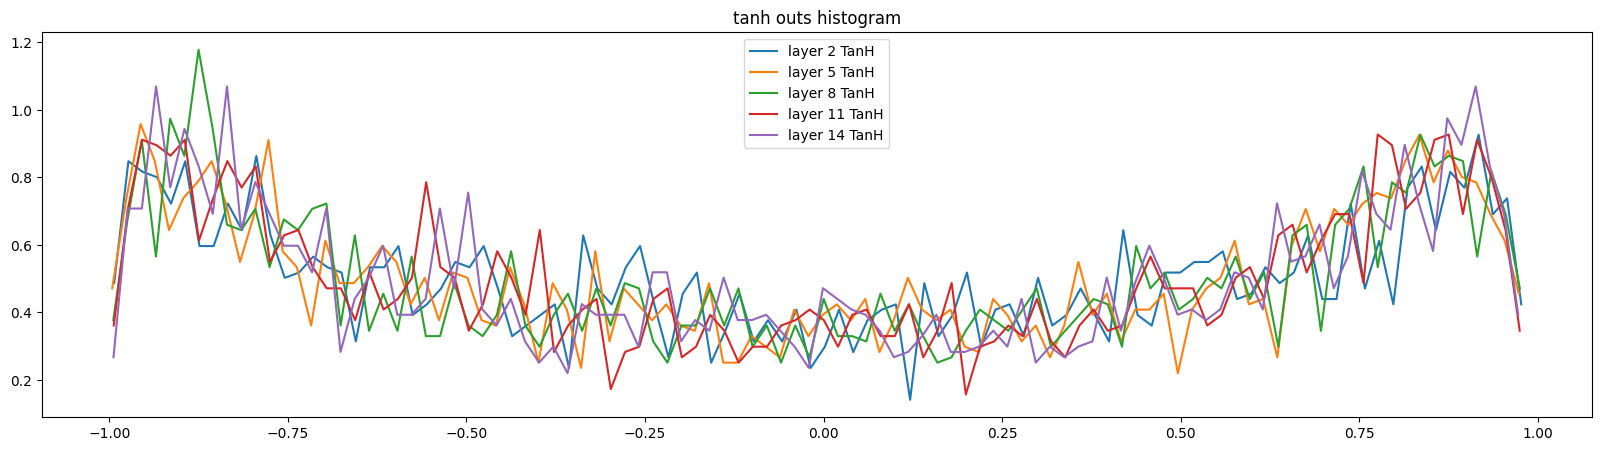

In [24]:
# visualize tanh value histogram
legends = []
plt.figure(figsize = (20, 5))
plt.title('tanh outs histogram')
for i, layer in enumerate(layers):
    if isinstance(layer, TanH):
        t = layer.out
        hy, hx = torch.histogram(t, density=True) # hx contains the bin edges
        print(f'layer {i} TanH: mean {t.mean():.2f}, std {t.std():.2f}, saturated {(t.abs() > .95).float().mean()*100:.2f}%')
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} TanH')
        plt.legend(legends)
        # plt.hist(t, bins=100)
        

# TanH Data Histogram
*Activations in the forward pass*

We want this to be well distributed.

You'll notice that if we do not use a gain (5/3 multiplicator for last but one layer), the saturation decreases to 0 and std keeps decreasing.
The further layers are basically shrinking to 0. Reason is tanh is a squashing function and some gain is necessary to fight the squashing.
High gain (say, 3) keeps the saturation quite high.
5/3 is a good gain to stabilize the NN when we have linear layers with tanh squashing. 

layer 2 TanH: mean -0.0000000000, std 0.0036829507
layer 5 TanH: mean -0.0000000000, std 0.0032626069
layer 8 TanH: mean -0.0000000000, std 0.0029737283
layer 11 TanH: mean 0.0000000000, std 0.0027411070
layer 14 TanH: mean -0.0000000000, std 0.0025842921


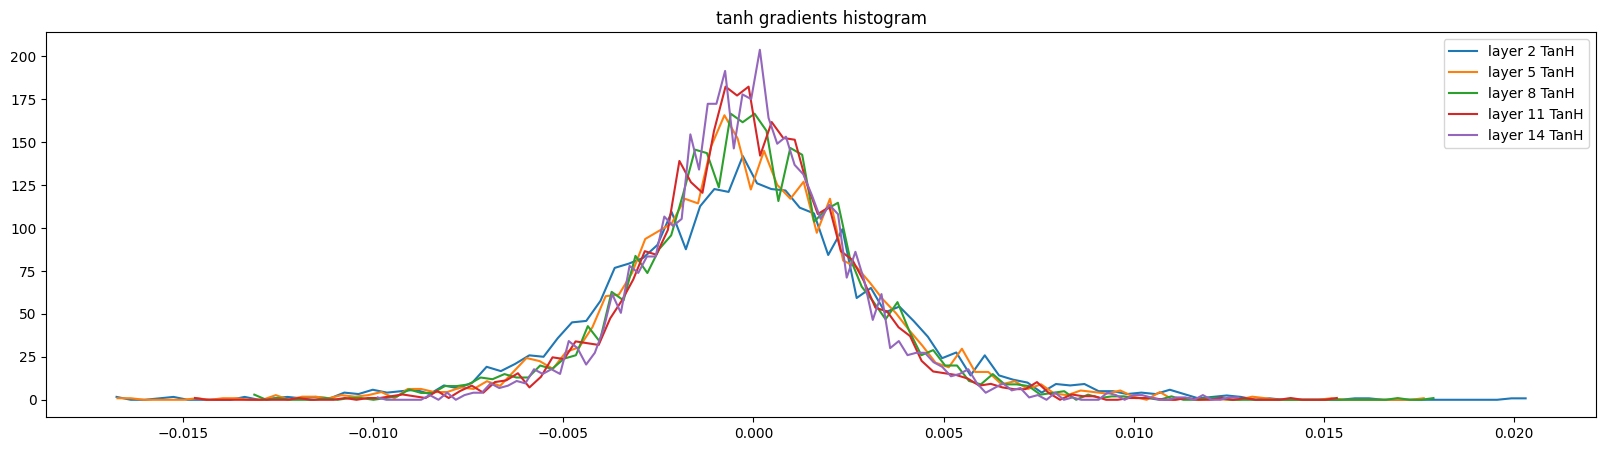

In [25]:
# visualize tanh gradient histogram
legends = []
plt.figure(figsize = (20, 5))
plt.title('tanh gradients histogram')
for i, layer in enumerate(layers):
    if isinstance(layer, TanH):
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True) # hx contains the bin edges
        print(f'layer {i} TanH: mean {t.mean():.10f}, std {t.std():.10f}')
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} TanH')
        plt.legend(legends)


# TanH Gradient Histogram
*Gradients in the backward pass*

We want the different layers to have roughly the same gradient histogram.

We don't want gradients to shrink or explode. We see they explode if gain is too high (3), shrink if gain is too low (1 or lower).
Intuitively, having the gradient histogram consistent shows that learning contribution of consistent.

Now, these tuning is important when we do not use BatchNorm.

## Why TanH Layer ?
If you just have a stack of linear layers without TanH (and gain set to 1), then it's easier to get a healthy activation histogram for each layer.
However, this is useless because no matter how many linear layers you stack up, it's equivalent to just one linear layer. All the (Wi * X + Bi) just collapse into one large W*X + B.
Technically though, this is equivalent only in the forward pass. There are some interesting effects in how the backward pass works, that we will not get into.

weight   (27, 10) | mean +0.0000000001 | std +0.0101988418 | grad:data ratio 0.0101884473
weight  (30, 100) | mean +0.0000922250 | std +0.0082384245 | grad:data ratio 0.0263583735
weight   (1, 100) | mean -0.0003999644 | std +0.0067220512 | grad:data ratio 0.3178889155
weight   (1, 100) | mean +0.0001454809 | std +0.0061359531 | grad:data ratio 0.2067617476
weight (100, 100) | mean +0.0000305258 | std +0.0073181037 | grad:data ratio 0.0437713899
weight   (1, 100) | mean -0.0003608798 | std +0.0063656643 | grad:data ratio 0.3123804331
weight   (1, 100) | mean -0.0009380654 | std +0.0052986261 | grad:data ratio 0.2168877125
weight (100, 100) | mean -0.0000185357 | std +0.0066620205 | grad:data ratio 0.0394989401
weight   (1, 100) | mean +0.0001110048 | std +0.0056496277 | grad:data ratio 0.3146810532
weight   (1, 100) | mean +0.0001847583 | std +0.0052337139 | grad:data ratio 0.2201200128
weight (100, 100) | mean -0.0000191468 | std +0.0058215130 | grad:data ratio 0.0346815921
weight   (

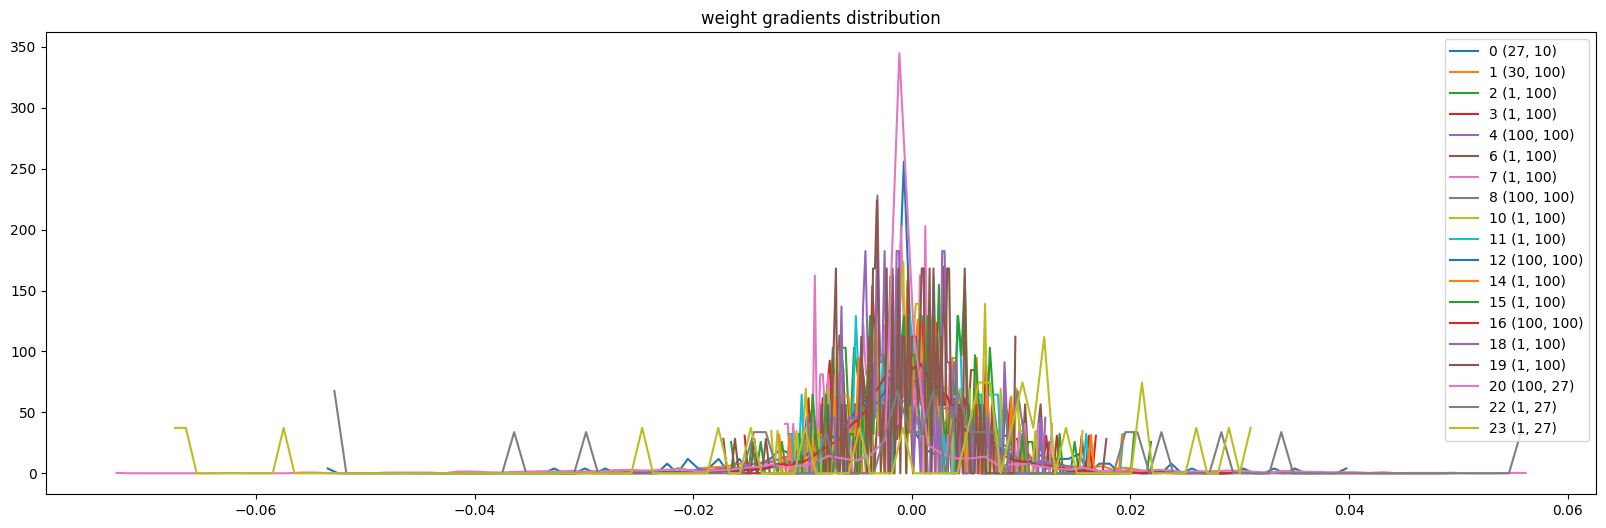

In [26]:
# visualize weight gradients histogram
legends = []
plt.figure(figsize = (20, 6))
plt.title('weight gradients distribution')
for i, p in enumerate(parameters):
    if p.ndim == 2: # only weight params are 2d        
        g = p.grad
        hy, hx = torch.histogram(g, density=True) # hx contains the bin edges
        print(f'weight {tuple(p.shape).__str__():>10} | mean {g.mean():+.10f} | std {g.std():+.10f} | grad:data ratio {g.std()/p.std():.10f}')
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)


# Weight Gradient Histogram

*Weights updated as part of gradient descent*

You want the grad:data ratio to be small. In our case, it's around 1000 times smaller for initial layers, which is ok.
Remember, the step update to data is the (learningrate * gradient). So, if gradient is too large compared to data, then we have a problem.
The last layer has gradients that are roughly 10x the standard deviation. This => the last layer gets trained 10x faster.

What we are technically looking for is the update to date ratio.

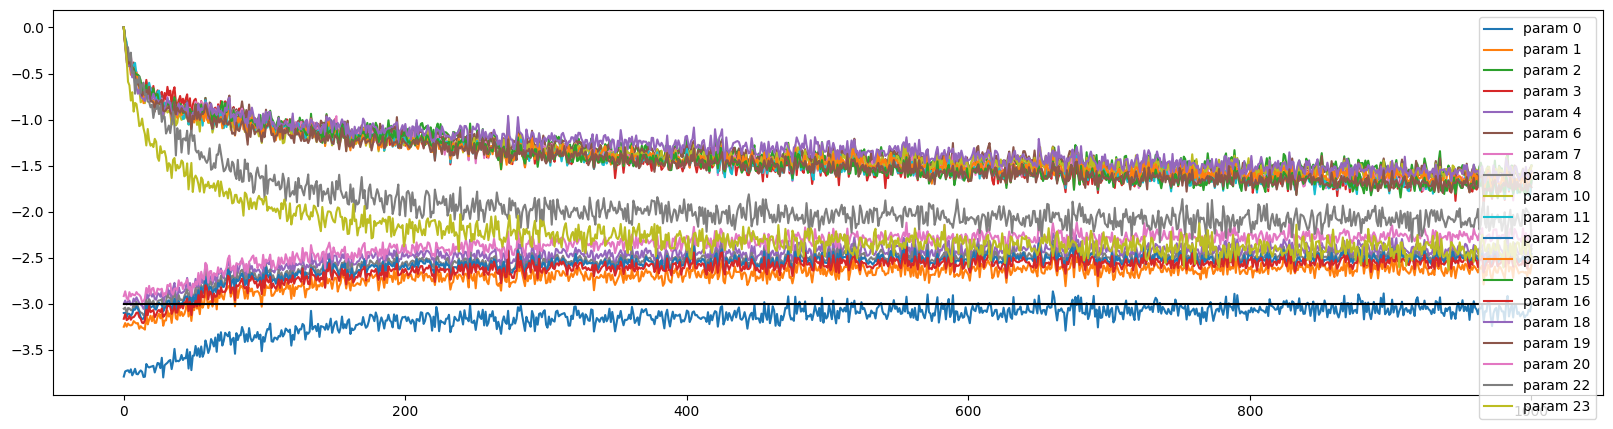

In [27]:
# visualize weight gradients to update histogram
legends = []
plt.figure(figsize = (20, 5))
for i, p in enumerate(parameters):
    if p.ndim == 2: # only weight params are 2d; 7 weight matrices: 1 vector lookup, 6 layers        
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.legend(legends)

plt.plot([0, len(ud)], [-3,-3], 'k') # guide line: ideal ratio is around 1e-3, to compare against


# Weight Update to Data Ratio

*Weights updated as part of gradient descent, showing updates to data*

We want most layers to be at or slightly above guideline.

**Higher than guideline**
Parameters are being updated too much

**Lower than guideline**
Parameters are not being updated fast enough (with enough magnitude)
If learning rate is too low (try 0.001), then this plot will reveal it.
This can be used as a systematic means to figure out what learning rate to use.

The reason the last layer has too many updates (especially initially), is it was artifically shrunk down to keep the initial soft-max not confident.